# Medicare Claims Analysis

Medicare is USA's largest government insurance program. It caters to US senior citizens aged 65+, and youths with disabilities. The program is adminstered by CMS (Center for Medicare and Medicaid Services). The data linked is from the CMS Website.


### Guidelines for the task
- Take the time to understand the business problem and to develop a thoughtful solution, we suggest taking a few hours to complete the task.
- Be prepared to talk through what you did during the task to a technical & non-technical audience.
- If there are parts of this EDA that you would do differently, or with more time, would try something else, please discuss these during the interview. 
- Please share code & relevant materials (slides, workbooks etc..) at least 24 hours prior to the interview



## Central Question: How does cost vary across different providers for different conditions?

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
slide_background_color = '#212121'
def set_preferred_options():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
    plt.style.use('dark_background')
    plt.facecolor=(.33, .33, .33)
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    # Then, "ALWAYS use sans-serif fonts"
    matplotlib.rcParams['font.family'] = "sans-serif"
set_preferred_options()

In [44]:

def generate_vertical_bar_graph(df, variable, 
                                chart_title="", 
                                variable_readable="", 
                                variable_labels={}):

    if(not(variable_readable)):
        variable_readable = variable

    if not(variable_labels):
        variable_labels={key: key for key in df[variable].unique().tolist()}
    
    variable_distribution = (df[variable]
                            .value_counts(normalize=True, sort=False) * 100
                            )
    
    fig, ax = plt.subplots(figsize=(6, 4), facecolor=slide_background_color)

    variable_distribution.plot(kind='bar', ax=ax)

    # Adds percentages above the bars
    for i, v in enumerate(variable_distribution):
        ax.text(i, v + 1, 
                f'{int(v)}%', 
                ha='center', 
                va='bottom',
                fontsize=10)

    ax.set_title(f'Distribution of {variable_readable}', fontsize=16, pad=20)
    ax.set_xlabel(variable_readable)

    # Set custom labels for x-axis ticks
    ax.set_xticks(range(len(variable_distribution)))
    ax.set_xticklabels(
        [variable_labels.get(key, key) for key in variable_distribution.index], 
        rotation=0)
    
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax.spines['top'].set_visible(False)   
    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.set_facecolor(slide_background_color) 
    plt.show()

def generate_horizontal_bar_graph(df, variable, chart_title="", 
                                  variable_readable="", 
                                  variable_labels={}):
    if(not(variable_readable)):
        variable_readable = variable

    if not(variable_labels):
        variable_labels={key: key for key in df[variable].unique().tolist()}

    variable_distribution = (df[variable]
                            .map(variable_labels)
                            .value_counts(normalize=True) * 100

                            )
    variable_distribution.sort_values(ascending=True, inplace=True)

    fig, ax = plt.subplots(figsize=(6, 12), facecolor=slide_background_color)


    variable_distribution.plot(kind='barh', ax=ax)

    # Adds percentages above the bars
    for i, v in enumerate(variable_distribution):
        ax.text(v + 1, i, 
                f'{int(v)}%', 
                ha='left', 
                va='center',
                fontsize=10)

    ax.set_title(f'Distribution of {variable_readable}', 
                 fontsize=16, 
                 pad=20, 
                 loc='center')
    ax.set_ylabel(variable_readable)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.spines['top'].set_visible(False)   
    ax.spines['right'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 
    ax.set_facecolor(slide_background_color) 
    plt.show()


def generate_conditions_summary(df, conditions_readable_map):
    '''
    
    '''
    # Create subplots with one column and as many rows as there are conditions
    num_conditions = len(conditions_readable_map)
    fig, axs = plt.subplots(
        nrows=num_conditions, 
        ncols=1, 
        figsize=(8, 0.45*num_conditions),
        facecolor=slide_background_color
        )
    fig.suptitle('Presence of Chronic Illnesses', fontsize=16)
    for i, (condition_variable_name, condition_contents) in enumerate(conditions_readable_map.items()):
        
        condition_readable_name = condition_contents[0]
        conditions_map = condition_contents[1]

        # Calculate the percentage of 'Yes's in the current condition column
        percentage_condition = (
            df[condition_variable_name]
            .value_counts(normalize=True) * 100
        ).loc[conditions_map['Yes']]

        axs[i].barh([condition_readable_name], [percentage_condition])

        # Display the percentage label at the bottom
        axs[i].text(x=0,
                    y=0,
                    s=f'{condition_readable_name}: {percentage_condition:.0f}% ',
                    ha='right',
                    va='center')
        axs[i].set_xlim(0, 100) 

        axs[i].set_yticks([])
        axs[i].set_xticks([]) 
        axs[i].spines['top'].set_visible(False)   
        axs[i].spines['right'].set_visible(False) 
        axs[i].spines['bottom'].set_visible(False) 
        axs[i].set_facecolor(slide_background_color) 

    # Just want the x axis ticks at the bottom
    axs[num_conditions - 1].set_xticks([20, 40, 60, 80, 100])  

    plt.tight_layout()
    plt.show()

def get_beneficiary_age(df, age_variable, reference_date_str):
    df[age_variable] = pd.to_datetime(df[age_variable], format='%Y%m%d')
    reference_date = datetime.strptime(reference_date_str, '%Y%m%d')
    df['age'] = (reference_date - df[age_variable]).astype('<m8[Y]')

    # Create a new categorical variable 'age_group'
    bins = [-float('inf'), 25, 65, 70, 75, 80, 85, 90, float('inf')]
    ages = ['1','2','3','4','5','6','7','8']

    df['age_group'] = pd.cut(df['age'], 
                             bins=bins, 
                             labels=ages,
                             right=False)
    return df

def customise_graph_dark_mode(axis):
    '''
    Make sure to run this before setting graph titles
    '''
    axis.set_facecolor('black') 
    axis.set_title('Sample Text', color='grey')
    axis.set_xlabel('Sample Text', color='grey')
    axis.set_ylabel('Sample Text', color='grey')
    axis.tick_params(axis='x', colors='grey')  
    axis.tick_params(axis='y', colors='grey')  
    axis.spines['bottom'].set_color('grey') 
    axis.spines['left'].set_color('grey')   
    axis.spines['top'].set_visible(False)   
    axis.spines['right'].set_visible(False) 
    

In [5]:
def get_data(file_path, char_columns):
    dtype_options = {column: "str" for column in char_columns}
    df = pd.read_csv(file_path, dtype=dtype_options)
    return df

In [6]:
THRESHOLD_CONDITIONS = 3
def display_dataframe_with_all_rows(df):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_colwidth', 100)
    print(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
#     pd.reset_option('display.max_colwidth')

def combine_conditions(row, columns_to_combine):
    ''' columns_to_combine is a dict'''
    conditions = []
    for col in columns_to_combine:
        condition_readable_name = columns_to_combine[col][0]
        conditions_map = columns_to_combine[col][1]

        if row[col] == conditions_map['Yes']:
            conditions.append(condition_readable_name)

    if conditions:
        if len(conditions) >=3:
            return 'Multiple'
        else:
            return ' | '.join(conditions)
    else:
        return 'None'
    
def categorise_multiple(row, columns_to_check):
    count_ones = sum(row[col] == 1 for col in columns_to_check)
    return 'Multiple' if count_ones > 3 else 'None'

def get_illness_var_type(df):
    df['illness_var_type'] = np.where(
    (df['combined_condition'] == 'Multiple') | (df['combined_condition'] == 'None'),
    df['combined_condition'],
    'Combination of 2 illnesses')
    return df



In [7]:
beneficiary_file_path = "./data/DE1_0_2009_Beneficiary_Summary_File_Sample_20.csv"
char_columns_in_beneficiary_data = [
    'BENE_SEX_IDENT_CD',
    'BENE_RACE_CD',
    'BENE_ESRD_IND',
    'SP_ALZHDMTA',
    'SP_CHF',
    'SP_CHRNKIDN',
    'SP_CNCR',
    'SP_COPD',
    'SP_DEPRESSN',
    'SP_DIABETES',
    'SP_ISCHMCHT',
    'SP_OSTEOPRS',
    'SP_RA_OA',
    'SP_STRKETIA'
]	


claims_file_path = "./data/DE1_0_2008_to_2010_Outpatient_Claims_Sample_20.csv"
char_columns_in_claims_data = [
    'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
    'ICD9_DGNS_CD_3','ICD9_DGNS_CD_4' ,'ICD9_DGNS_CD_5',
    'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
    'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
    'ICD9_PRCDR_CD_1', 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3',
    'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6'     
]



In [8]:
beneficiary_df = get_data(beneficiary_file_path, 
                          char_columns_in_beneficiary_data)
claims_df = get_data(claims_file_path,
                     char_columns_in_claims_data)

In [9]:
beneficiary_df = get_beneficiary_age(beneficiary_df,
                                     'BENE_BIRTH_DT',
                                     reference_date_str='20101212'
                                     )


In [54]:
def apply_currency_formatting(amount):
    return '${:,.0f}'.format(amount)


claims_df['CLM_PMT_AMT'] = claims_df['CLM_PMT_AMT'].apply(
    lambda x: apply_currency_formatting(x))
beneficiary_df['MEDREIMB_OP'] = beneficiary_df['MEDREIMB_OP'].apply(
    lambda x: apply_currency_formatting(x)
)

In [10]:
conditions_to_combine = {'SP_ALZHDMTA': 'Alzheimer',
                      'SP_CHF': 'Heart Failure',
                      'SP_CHRNKIDN': 'Kidney Disease',
                      'SP_CNCR': 'Cancer',
                      'SP_COPD': 'COPD', 
                      'SP_DEPRESSN': 'Depression',
                      'SP_DIABETES': 'Diabetes',
                      'SP_ISCHMCHT': 'Ischemic Heart Disease',
                      'SP_OSTEOPRS': 'Osteoporosis',
                      'SP_RA_OA': 'Rheumatoid Arthritis or Osteoarthritis',
                      'SP_STRKETIA': 'Stroke'  
}
sp_conditions_map = {
'Yes':'1',
'No':'2'
}
esrd_conditions_map = {
    'No':'0',
    'Yes':'Y'
}
conditions_readable_map = {
    'BENE_ESRD_IND':['End stage renal disease', esrd_conditions_map],
    'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
    'SP_CHF':['Heart Failure', sp_conditions_map],
    'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
    'SP_CNCR':['Cancer', sp_conditions_map],
    'SP_COPD':['Chronic Obstructive Pulmonary Disease', sp_conditions_map],
    'SP_DEPRESSN':['Depression', sp_conditions_map],
    'SP_DIABETES':['Diabetes', sp_conditions_map],
    'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
    'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
    'SP_RA_OA':['Rheumatoid Arthritis or Osteoarthritis', sp_conditions_map],
    'SP_STRKETIA':['Stroke' , sp_conditions_map],
}


beneficiary_df['combined_condition'] = beneficiary_df.apply(combine_conditions, 
                                    columns_to_combine=conditions_readable_map, 
                                    axis=1)
beneficiary_df['combined_condition'].value_counts()
beneficiary_df = get_illness_var_type(beneficiary_df)



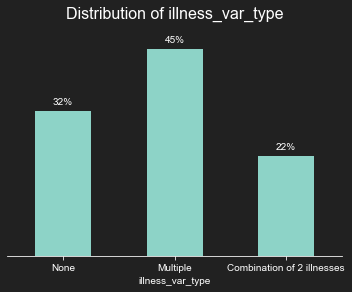

In [11]:
generate_vertical_bar_graph(df=beneficiary_df, 
                        variable="illness_var_type")

In [12]:
illness_combination_df = beneficiary_df[
    beneficiary_df['combined_condition'].str.contains('\|')
    ]
illness_combination_df['combined_condition'].value_counts()

Diabetes | Ischemic Heart Disease                  1969
Heart Failure | Ischemic Heart Disease             1415
Depression | Ischemic Heart Disease                 744
Ischemic Heart Disease | Osteoporosis               697
Heart Failure | Diabetes                            618
                                                   ... 
End stage renal disease | Cancer                      8
Rheumatoid Arthritis or Osteoarthritis | Stroke       7
Cancer | Stroke                                       4
Chronic Obstructive Pulmonary Disease | Stroke        2
End stage renal disease | Stroke                      2
Name: combined_condition, Length: 66, dtype: int64

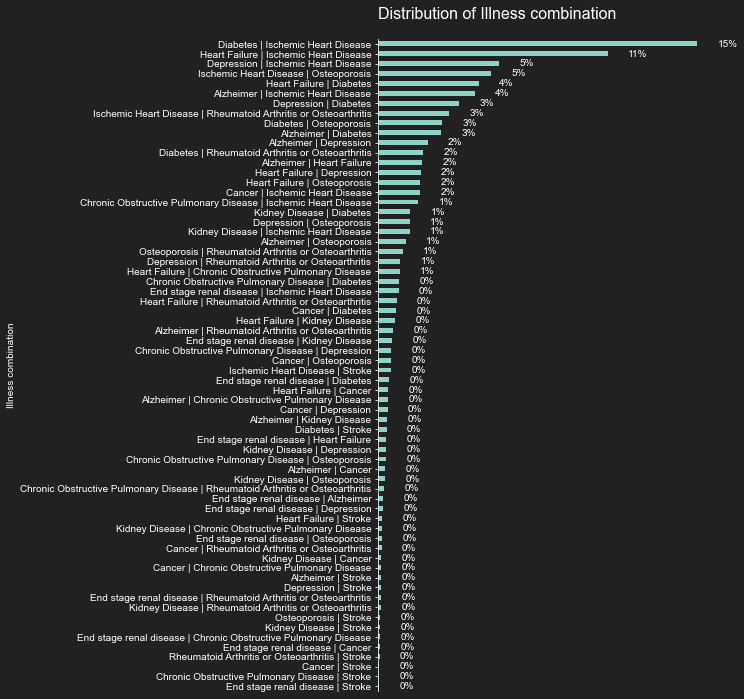

In [43]:

generate_horizontal_bar_graph(df=illness_combination_df,
                            variable="combined_condition", 
                            chart_title="", 
                            variable_readable="Illness combination")

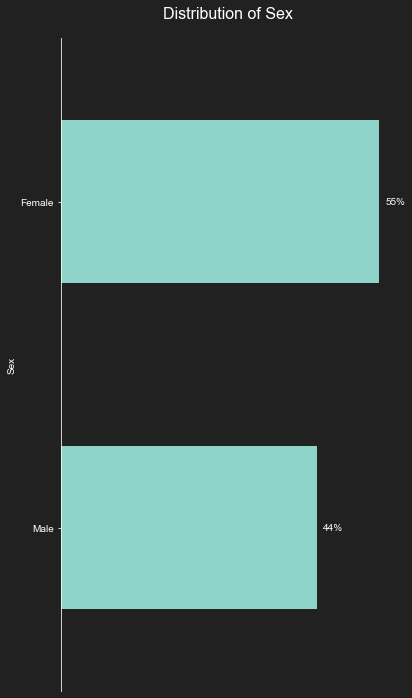

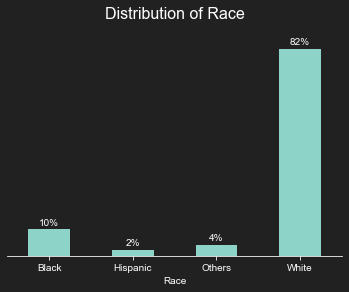

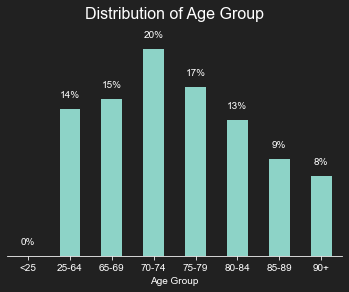

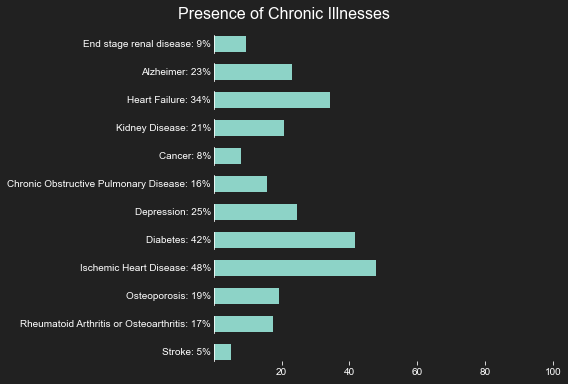

In [33]:
def generate_descriptive_graphs_beneficiary(beneficiary_df):
    sex_labels = {'1':'Male', '2':'Female'}
    race_labels = {'1': 'White', '2': 'Black', '3': 'Others', '5': 'Hispanic'}
    sp_conditions_map = {
    'Yes':'1',
    'No':'2'
    }
    esrd_conditions_map = {
        'No':'0',
        'Yes':'Y'
    }
    conditions_readable_map = {
        'BENE_ESRD_IND':['End stage renal disease', esrd_conditions_map],
        'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
        'SP_CHF':['Heart Failure', sp_conditions_map],
        'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
        'SP_CNCR':['Cancer', sp_conditions_map],
        'SP_COPD':['Chronic Obstructive Pulmonary Disease', sp_conditions_map],
        'SP_DEPRESSN':['Depression', sp_conditions_map],
        'SP_DIABETES':['Diabetes', sp_conditions_map],
        'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
        'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
        'SP_RA_OA':['Rheumatoid Arthritis or Osteoarthritis', sp_conditions_map],
        'SP_STRKETIA':['Stroke' , sp_conditions_map],
    }

    age_labels = {
        '1': '<25',
        '2': '25-64',
        '3': '65-69',
        '4': '70-74',
        '5': '75-79',
        '6': '80-84',
        '7': '85-89',
        '8': '90+',
    }

    
    generate_horizontal_bar_graph(df=beneficiary_df, 
                            variable="BENE_SEX_IDENT_CD",
                            chart_title="",
                            variable_readable="Sex",
                            variable_labels=sex_labels)
    
    generate_vertical_bar_graph(df=beneficiary_df, 
                            variable="BENE_RACE_CD",
                            chart_title="",
                            variable_readable="Race",
                            variable_labels=race_labels)
    
    generate_vertical_bar_graph(df=beneficiary_df, 
                        variable="age_group",
                        variable_readable="Age Group",
                        chart_title="",
                        variable_labels=age_labels)
    
    generate_conditions_summary(beneficiary_df, conditions_readable_map)
    
generate_descriptive_graphs_beneficiary(beneficiary_df)

None    114641
Name: combined_condition, dtype: int64

In [123]:
df = beneficiary_df
df['MEDREIMB_OP'][df['MEDREIMB_OP'] < 0] = 0
df['MEDREIMB_OP'].describe()

/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count   114641.00
mean       762.04
std       1876.64
min          0.00
25%          0.00
50%        120.00
75%        800.00
max      47010.00
Name: MEDREIMB_OP, dtype: float64

TypeError: Horizontal orientation requires numeric `x` variable.

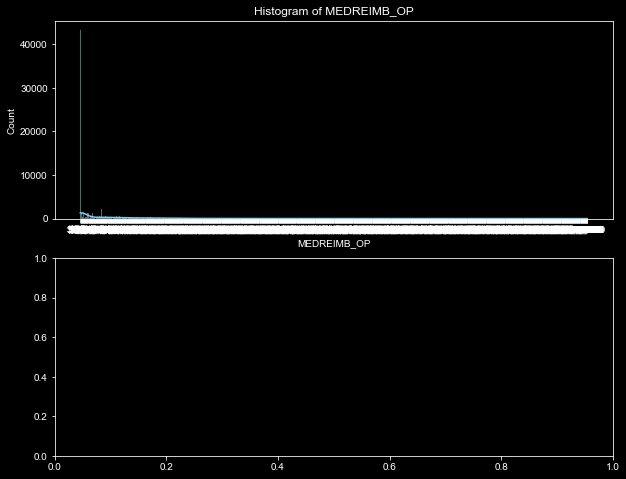

In [57]:





# Create a figure with two subplots (one for histogram and one for boxplot)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the histogram
sns.histplot(beneficiary_df['MEDREIMB_OP'], bins=30, kde=True, color='skyblue', ax=ax1)
ax1.set_title('Histogram of MEDREIMB_OP')
ax1.set_xlabel('MEDREIMB_OP')

# Plot the boxplot
sns.boxplot(x=beneficiary_df['MEDREIMB_OP'], ax=ax2, color='lightcoral')
ax2.set_title('Boxplot of MEDREIMB_OP')
ax2.set_xlabel('MEDREIMB_OP')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()



In [ ]:
beneficiary_df.head(10)

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,000002F7E0A96C32,19190701,NaN,2,2,0,5,400,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00001C24EE7B06AC,19360501,NaN,1,1,0,11,530,12,12,...,2,0.0,0.0,0.0,200.0,40.0,0.0,800.0,260.0,0.0
2,000072CF62193213,19310401,NaN,2,1,0,34,120,12,12,...,2,0.0,0.0,0.0,130.0,70.0,0.0,440.0,30.0,50.0
3,0000DCD33779ED8A,19420501,NaN,2,2,0,11,190,12,12,...,2,0.0,0.0,0.0,90.0,20.0,0.0,930.0,200.0,0.0
4,0000F1EB530967F3,19350401,NaN,2,1,0,23,720,12,12,...,2,0.0,0.0,0.0,70.0,200.0,0.0,4950.0,1340.0,0.0
5,0001B495F55E2DFA,19410801,NaN,2,1,0,34,170,12,12,...,2,0.0,0.0,0.0,1100.0,400.0,0.0,5210.0,1380.0,50.0
6,00028CFDA8612B87,19431001,NaN,2,1,0,14,740,12,12,...,2,0.0,0.0,0.0,1300.0,110.0,0.0,1600.0,410.0,0.0
7,00036DA073115F08,19430901,NaN,2,1,0,36,310,12,12,...,2,0.0,0.0,0.0,2280.0,280.0,0.0,1090.0,250.0,50.0
8,0003A64D9776B051,19420901,NaN,2,1,0,45,100,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,200.0,40.0,0.0
9,0003D0FBC87B8600,19431201,NaN,1,2,0,3,130,12,12,...,2,8000.0,1068.0,0.0,270.0,110.0,0.0,1640.0,500.0,0.0


In [75]:
beneficiary_df.describe()

,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
count,114641.00,1830.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00,114641.00
mean,19364038.68,20090634.28,1.55,1.28,25.73,366.37,11.23,11.11,3.33,9.07,1.77,1.66,1.79,1.92,1.84,1.75,1.58,1.52,1.81,1.83,1.95,2158.44,247.42,101.53,762.03,234.91,30.71,1337.59,374.56,21.11
std,125640.13,344.15,0.50,0.75,15.57,266.03,2.93,3.09,5.30,4.87,0.42,0.47,0.41,0.27,0.36,0.43,0.49,0.50,0.39,0.38,0.22,7167.90,781.24,1951.36,1876.65,539.39,414.68,1525.17,423.54,96.01
min,19090101.00,20090101.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-8000.00,0.00,0.00,-90.00,0.00,0.00,0.00,0.00,0.00
25%,19281101.00,20090301.00,1.00,1.00,11.00,141.00,12.00,12.00,0.00,6.00,2.00,1.00,2.00,2.00,2.00,2.00,1.00,1.00,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,90.00,20.00,0.00
50%,19360501.00,20090601.00,2.00,1.00,25.00,330.00,12.00,12.00,0.00,12.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,0.00,0.00,0.00,120.00,30.00,0.00,900.00,250.00,0.00
75%,19420301.00,20090901.00,2.00,1.00,39.00,550.00,12.00,12.00,12.00,12.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,0.00,0.00,0.00,800.00,240.00,0.00,1980.00,560.00,0.00
max,19831201.00,20091201.00,2.00,5.00,54.00,999.00,12.00,12.00,12.00,12.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,136000.00,39340.00,86000.00,47010.00,11480.00,21000.00,16930.00,4410.00,2400.00


### 2. Data Cleaning
The beneficiary summary file has several chronic illness columns for each member. These are Boolean fields.

- Convert these columns into a single categorical variable, concatenating multiple true diagnoses.

- If a member has 3 or more chronic conditions, categorise these as “Multiple”
- Join claims & benefit data

### Data Quality checks

- Beneficiary data is unique at `DESYNPUF_ID` - which represents the beneficiary code/ patient code according to documentation${^1}$

- The claims data is not unique on `CLM_ID`. However it is unique at `CLM_ID` x `Segment` level.
Wherever segment = 2, most of the variables are `NaN`s, excepting Provider Institution. From looking at this data, my hypothesis is that the claims were amended, with a new Provider Info, or claim amount. For this analysis, I'm dropping the rows where the segment = 2, and most of the variables are `NaN`

- There are some claims where the `CLM_PMT_AMT` is negative, which can occur in
the following cases:
    - Where the beneficiary is charged a coinsurance amount and this is higher than the amount Medicare pays
    - Where the deductible exceeds the amount Medicare pays
    
    In both the above situations the claim amount does not represent the cost of the treatment, hence this has been removed from the dataset

- `MEDREIMB_OP` in the beneficiary dataset denotes the total annual medical Outpatient Reimbursement from Medicaid. There are some beneficiaries in the dataset that have negative due to similar reasons as for `CLM_PMT_AMT`. However these are not removed, as their could be non-negative claim amounts from the same benficiary. I've replaced negative values with
0 for this dataset.



In [48]:
claims_df = claims_df.drop_duplicates(subset=['CLM_ID'])
claims_df = claims_df[claims_df['CLM_PMT_AMT'] >= 0]
duplicate_claims = claims_df[claims_df.duplicated(subset=['CLM_ID'], keep=False)]
beneficiary_df['MEDREIMB_OP'][beneficiary_df['MEDREIMB_OP'] < 0] = 0

# claims_df = claims_df[~claims_df.duplicated(subset=['CLM_ID'], keep=False)]

/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [49]:
duplicate_claims.head(50)

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,ADMTNG_ICD9_DGNS_CD,HCPCS_CD_1,HCPCS_CD_2,HCPCS_CD_3,HCPCS_CD_4,HCPCS_CD_5,HCPCS_CD_6,HCPCS_CD_7,HCPCS_CD_8,HCPCS_CD_9,HCPCS_CD_10,HCPCS_CD_11,HCPCS_CD_12,HCPCS_CD_13,HCPCS_CD_14,HCPCS_CD_15,HCPCS_CD_16,HCPCS_CD_17,HCPCS_CD_18,HCPCS_CD_19,HCPCS_CD_20,HCPCS_CD_21,HCPCS_CD_22,HCPCS_CD_23,HCPCS_CD_24,HCPCS_CD_25,HCPCS_CD_26,HCPCS_CD_27,HCPCS_CD_28,HCPCS_CD_29,HCPCS_CD_30,HCPCS_CD_31,HCPCS_CD_32,HCPCS_CD_33,HCPCS_CD_34,HCPCS_CD_35,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45


In [56]:
claims_df['PRVDR_NUM'].value_counts()

0502NA    9621
2201DT    5518
0505TK    5408
2301GU    4211
3400ZQ    3810
          ... 
1613YK       1
2413QA       1
4528RA       1
0325ZB       1
0213BD       1
Name: PRVDR_NUM, Length: 6297, dtype: int64

### Data joining

In [50]:
print("# of rows in beneficiary data", len(beneficiary_df))
print("# of rows in claims data", len(claims_df))

# of rows in beneficiary data 114641
# of rows in claims data 776673


In [51]:
beneficiary_claims_df = pd.merge(beneficiary_df, claims_df, 
                                 on='DESYNPUF_ID', how='inner')
print(len(beneficiary_claims_df))

774696


In [60]:

condition_grouped_df = beneficiary_claims_df.groupby('combined_condition').agg(
    total_cost=('CLM_PMT_AMT', 'sum'),
    beneficiary_count=('DESYNPUF_ID', 'nunique'),  
    claim_count=('CLM_ID', 'count')  
).reset_index()

condition_grouped_df['cost_per_member_per_illness'] = (condition_grouped_df['total_cost'] / 
                                                       condition_grouped_df['beneficiary_count'])

condition_grouped_df.sort_values(by='cost_per_member_per_illness', ascending=False, inplace=True)

print("Chronic Illness Combinations with Total Cost in Decreasing Order:")
condition_grouped_df

Chronic Illness Combinations with Total Cost in Decreasing Order:


,combined_condition,total_cost,beneficiary_count,claim_count,cost_per_member_per_illness
72,Multiple,169680360.00,51333,597369,3305.48
39,End stage renal disease | Cancer,25460.00,8,66,3182.50
48,End stage renal disease | Stroke,6070.00,2,40,3035.00
16,Cancer | Osteoporosis,175780.00,77,656,2282.86
47,End stage renal disease | Rheumatoid Arthritis...,31580.00,14,109,2255.71
...,...,...,...,...,...
49,Heart Failure,1163740.00,1131,5641,1028.95
37,End stage renal disease,135930.00,141,627,964.04
46,End stage renal disease | Osteoporosis,16960.00,18,76,942.22
69,Kidney Disease | Osteoporosis,32850.00,36,164,912.50


In [53]:
import pandas as pd

# Create a sample DataFrame
data = {'Name': ['John', 'Jane', 'Bob'],
        'Age': [28, 35, 42],
        'Salary': [50000, 75000, 60000]}

df = pd.DataFrame(data)

# Define a formatting function
def highlight_salary(value):
    if value > 60000:
        return 'color: green'
    else:
        return 'color: red'

# Apply the formatting function to the 'Salary' column
styled_df = df.style.applymap(highlight_salary, subset=['Salary'])

# Display the styled DataFrame
styled_df


,Name,Age,Salary
0,John,28,50000
1,Jane,35,75000
2,Bob,42,60000


In [59]:
provider_condition_grouped_df = (beneficiary_claims_df.
                                 groupby(['AT_PHYSN_NPI', 'combined_condition']).
                                 agg(total_cost=('CLM_PMT_AMT', 'sum'),
                                     beneficiary_count=('DESYNPUF_ID', 'nunique'),
                                    )
                                ).reset_index()

provider_condition_grouped_df['cost_per_member_per_provider'] = (
    provider_condition_grouped_df['total_cost'] / 
    provider_condition_grouped_df['beneficiary_count'])

provider_condition_grouped_df

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member_per_provider
0,102408.00,Ischemic Heart Disease,200.00,1,200.00
1,102408.00,Multiple,2220.00,4,555.00
2,325865.00,Multiple,10.00,1,10.00
3,511156.00,Multiple,160.00,2,80.00
4,572186.00,Multiple,10.00,1,10.00
...,...,...,...,...,...
202013,9999557961.00,Multiple,200.00,1,200.00
202014,9999602306.00,Multiple,100.00,1,100.00
202015,9999602306.00,None,10.00,1,10.00
202016,9999615484.00,Multiple,600.00,1,600.00


In [54]:
grouped_stats_df = pd.merge(provider_condition_grouped_df, condition_grouped_df, on=['combined_condition'])
# grouped_stats_df = grouped_stats_df.drop(['total_cost', 'beneficiary_count', 'claim_count'], axis=1)
grouped_stats_df['diff'] = grouped_stats_df['cost_per_member_per_illness'] - grouped_stats_df['cost_per_member_per_provider']
grouped_stats_df
grouped_stats_df = grouped_stats_df[grouped_stats_df['beneficiary_count_x'] > 1]

grouped_stats_df.sort_values(by=['AT_PHYSN_NPI','diff'], ascending=False)

,AT_PHYSN_NPI,combined_condition,total_cost_x,beneficiary_count_x,cost_per_member_per_provider,total_cost_y,beneficiary_count_y,claim_count,cost_per_member_per_illness,diff
98344,9999469755.00,Multiple,50.00,2,25.00,168373920.00,50729,594603,3319.09,3294.09
98343,9999354704.00,Multiple,4620.00,8,577.50,168373920.00,50729,594603,3319.09,2741.59
98342,9999234722.00,Multiple,180.00,3,60.00,168373920.00,50729,594603,3319.09,3259.09
98339,9999039484.00,Multiple,550.00,5,110.00,168373920.00,50729,594603,3319.09,3209.09
98338,9999035093.00,Multiple,280.00,3,93.33,168373920.00,50729,594603,3319.09,3225.75
...,...,...,...,...,...,...,...,...,...,...
10606,1159725.00,Multiple,3500.00,3,1166.67,168373920.00,50729,594603,3319.09,2152.42
10605,1053861.00,Multiple,8670.00,18,481.67,168373920.00,50729,594603,3319.09,2837.42
10604,1005544.00,Multiple,790.00,10,79.00,168373920.00,50729,594603,3319.09,3240.09
10600,511156.00,Multiple,160.00,2,80.00,168373920.00,50729,594603,3319.09,3239.09


In [30]:

# Filter out cases where there is only 1 member
provider_condition_grouped_df = provider_condition_grouped_df[provider_condition_grouped_df['beneficiary_count'] > 1]

# Calculate cost per member and add it to the DataFrame
provider_condition_grouped_df['cost_per_member'] = (

    provider_condition_grouped_df['total_cost'] / 
    provider_condition_grouped_df['beneficiary_count'])

provider_condition_grouped_df

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member
1,102408.00,Multiple,2220.00,4,555.00
3,511156.00,Multiple,160.00,2,80.00
12,1005544.00,Multiple,790.00,10,79.00
19,1053861.00,Multiple,8670.00,18,481.67
21,1159725.00,Multiple,3500.00,3,1166.67
...,...,...,...,...,...
204380,9999035093.00,Multiple,280.00,3,93.33
204381,9999039484.00,Multiple,550.00,5,110.00
204386,9999234722.00,Multiple,180.00,3,60.00
204387,9999354704.00,Multiple,4620.00,8,577.50


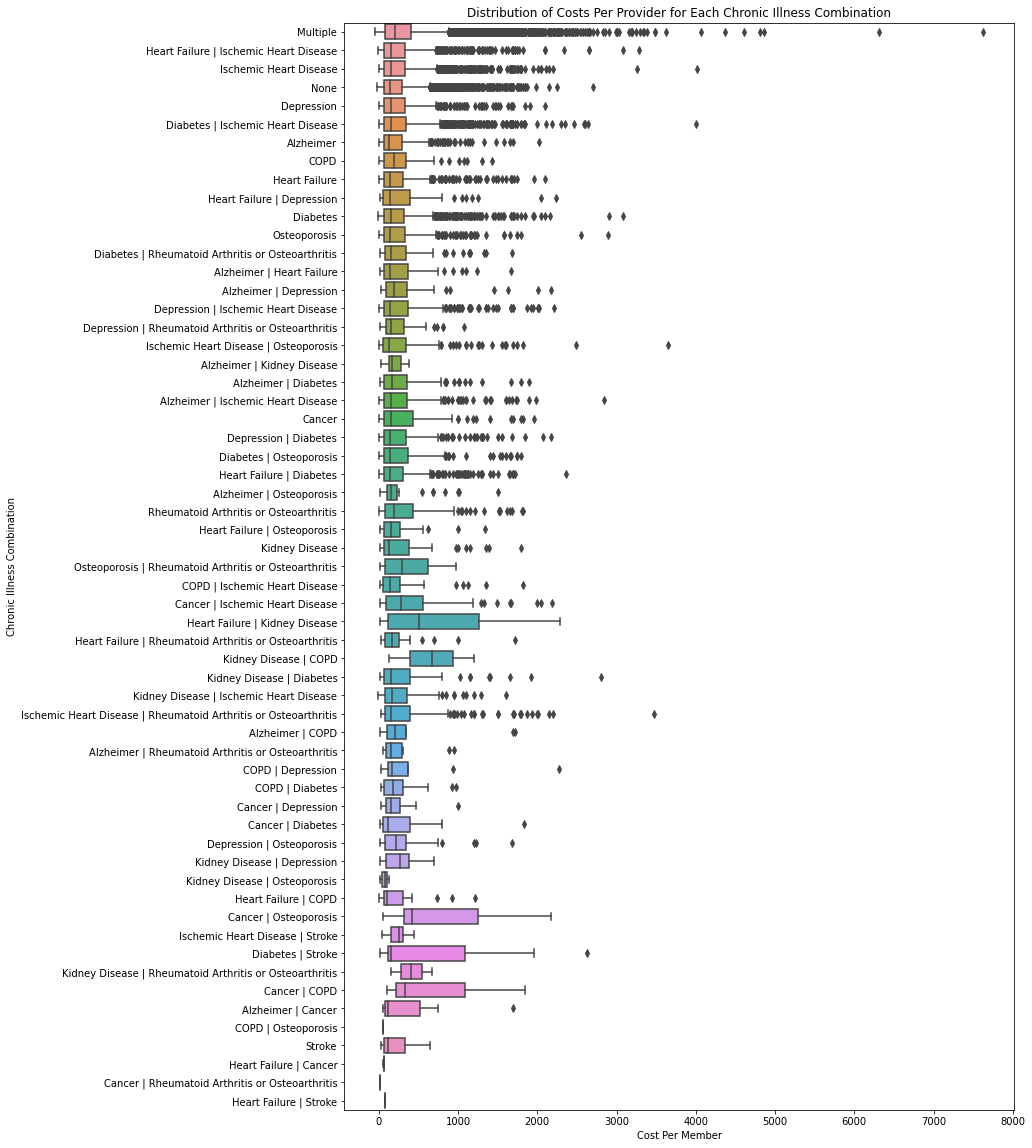

In [19]:

# Create a horizontal boxplot using seaborn
plt.figure(figsize=(12, 20))
sns.boxplot(x='cost_per_member', y='combined_condition', data=provider_condition_grouped_df)

# Customize the plot
plt.title('Distribution of Costs Per Provider for Each Chronic Illness Combination')
plt.xlabel('Cost Per Member')
plt.ylabel('Chronic Illness Combination')

# Show the plot
plt.show()


In [20]:
filtered_df = beneficiary_claims_df[
    (provider_condition_grouped_df['combined_condition'] != 'Multiple') & 
    (provider_condition_grouped_df['combined_condition'] != 'None')
    ].sort_values(by=['AT_PHYSN_NPI', 'combined_condition'])


Providers Consistently Expensive Across Chronic Illnesses (Lowest Standard Deviation):
                                   combined_condition  cost_per_member
31                                  Diabetes | Stroke          1077.22
16                                      Cancer | COPD           948.08
47                              Kidney Disease | COPD           760.14
38                     Heart Failure | Kidney Disease           739.12
11                                  COPD | Depression           725.49
20                              Cancer | Osteoporosis           725.46
1                                    Alzheimer | COPD           687.15
2                                  Alzheimer | Cancer           607.29
44  Ischemic Heart Disease | Rheumatoid Arthritis ...           519.22
49                          Kidney Disease | Diabetes           484.24
19                    Cancer | Ischemic Heart Disease           480.90
18                                  Cancer | Diabetes        

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member
39,2258359.00,Heart Failure | Ischemic Heart Disease,1030.00,2,515.00
40,2258359.00,Ischemic Heart Disease,830.00,2,415.00
66,3873846.00,Depression,80.00,2,40.00
124,7369113.00,Ischemic Heart Disease,100.00,2,50.00
145,8234489.00,Ischemic Heart Disease,1280.00,2,640.00
...,...,...,...,...,...
204124,9983663018.00,Ischemic Heart Disease,1140.00,2,570.00
204163,9986377632.00,Diabetes | Ischemic Heart Disease,50.00,2,25.00
204197,9989157751.00,Diabetes | Rheumatoid Arthritis or Osteoarthritis,600.00,2,300.00
204212,9989872252.00,Heart Failure,170.00,2,85.00


In [22]:
(provider_condition_grouped_df
 .sort_values(by=['AT_PHYSN_NPI', 'combined_condition']))

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member
1,102408.00,Multiple,2220.00,4,555.00
3,511156.00,Multiple,160.00,2,80.00
12,1005544.00,Multiple,790.00,10,79.00
19,1053861.00,Multiple,8670.00,18,481.67
21,1159725.00,Multiple,3500.00,3,1166.67
...,...,...,...,...,...
204380,9999035093.00,Multiple,280.00,3,93.33
204381,9999039484.00,Multiple,550.00,5,110.00
204386,9999234722.00,Multiple,180.00,3,60.00
204387,9999354704.00,Multiple,4620.00,8,577.50


In [42]:
grouped_stats = (filtered_df
                 .groupby(['AT_PHYSN_NPI', 'combined_condition'])['cost_per_member']
                 .agg(['mean', 'median', 'std', 'count'])
                 .reset_index())
grouped_stats_df = pd.merge(grouped_stats, condition_grouped_df, on=['combined_condition'])
# grouped_stats_df = grouped_stats_df.drop(['total_cost', 'beneficiary_count', 'claim_count'], axis=1)
grouped_stats_df['diff'] = grouped_stats_df['median'] - grouped_stats_df['cost_per_member']


grouped_stats_df.sort_values(by=['diff'], ascending=False)

            

,AT_PHYSN_NPI,combined_condition,mean,median,std,count,cost_per_member,diff
1128,682792263.00,Ischemic Heart Disease,4015.00,4015.00,nan,1,1218.24,2796.76
4934,5088396912.00,Diabetes | Ischemic Heart Disease,4005.00,4005.00,nan,1,1595.07,2409.93
9432,1507715206.00,Ischemic Heart Disease | Osteoporosis,3645.00,3645.00,nan,1,1404.68,2240.32
3010,8330940486.00,Ischemic Heart Disease,3260.00,3260.00,nan,1,1218.24,2041.76
12157,8244465611.00,Ischemic Heart Disease | Rheumatoid Arthritis ...,3475.00,3475.00,nan,1,1626.60,1848.40
...,...,...,...,...,...,...,...,...
11815,865386227.00,Kidney Disease | Diabetes,25.00,25.00,nan,1,2466.00,-2441.00
11885,9920136071.00,Kidney Disease | Diabetes,25.00,25.00,nan,1,2466.00,-2441.00
11825,1874552565.00,Kidney Disease | Diabetes,20.00,20.00,nan,1,2466.00,-2446.00
11812,524431244.00,Kidney Disease | Diabetes,10.00,10.00,nan,1,2466.00,-2456.00


In [44]:
# Filter groups with count greater than 1
grouped_stats_filtered = grouped_stats_df[grouped_stats_df['count'] > 1]

# Reset index after filtering
grouped_stats_filtered = grouped_stats_filtered.reset_index(drop=True)
grouped_stats_filtered.sort_values(by=['diff'], ascending=False)

,AT_PHYSN_NPI,combined_condition,mean,median,std,count,cost_per_member,diff


In [60]:
average_cost_per_provider = provider_condition_grouped_df.groupby(['AT_PHYSN_NPI', 'combined_condition'])['cost_per_member_per_provider'].mean().reset_index()

# Step 2: Identify providers with consistently high average costs across chronic illnesses
consistently_expensive_providers = average_cost_per_provider.groupby('AT_PHYSN_NPI')['cost_per_member_per_provider'].mean().sort_values(ascending=False)

# Display the results
print(consistently_expensive_providers.head(50))

AT_PHYSN_NPI
9453890658.00   7630.00
3304695316.00   6270.00
5532434557.00   6100.00
5065277402.00   5200.00
2851549369.00   5100.00
8784806690.00   4064.00
2552137585.00   3600.00
6845950794.00   3490.00
2888845858.00   3430.00
4853184048.00   3400.00
5968076347.00   3390.00
3499575906.00   3320.00
7926849493.00   3320.00
7913110990.00   3300.00
3748050683.00   3300.00
5492984529.00   3300.00
5649515602.00   3300.00
9839603672.00   3300.00
3714969518.00   3300.00
1780551677.00   3300.00
9718434535.00   3300.00
3015790154.00   3300.00
758688883.00    3300.00
6319147644.00   3300.00
4836022017.00   3300.00
5377555873.00   3300.00
6270549830.00   3300.00
3750646945.00   3300.00
3943201081.00   3300.00
6440100449.00   3300.00
9077125405.00   3300.00
2480969570.00   3300.00
5935194709.00   3300.00
5195268143.00   3300.00
7582271488.00   3300.00
8741926060.00   3300.00
460397080.00    3300.00
3291568729.00   3300.00
6214557395.00   3300.00
3739978132.00   3300.00
4240972019.00   3300.00
454

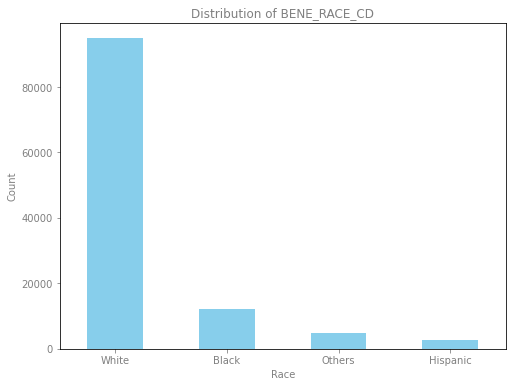

In [24]:


for column in char_columns_in_beneficiary_data: 
    print(f"Summary for {column}:")
    value_counts = beneficiary_df[column].value_counts()
    total_entries = len(beneficiary_df[column])
    
    for value, count in value_counts.items():
        percentage = (count / total_entries) * 100
        print(f"{value}: {count} ({percentage:.2f}%)")
    
    print("\n")


### References
1. CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_DUG.pdf]
2. Codebook for CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/files/document/de-10-codebook.pdf-0]